# Определение возраста покупателей

# Исследовательский анализ данных

## Исследовательский анализ данных

**Импорт библиотек**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Чтение файлов**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Просмотр данных выборки**

In [23]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим размер выборки

In [4]:
labels.shape

(7591, 2)

In [25]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим диаграмму распределения возраста в выборке

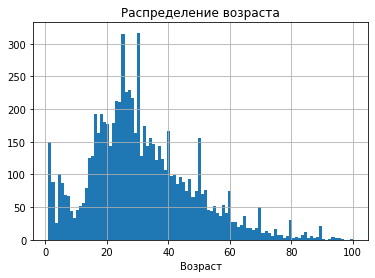

In [18]:
labels.hist(bins=100)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.show()

Напечатаем 16 фотографий

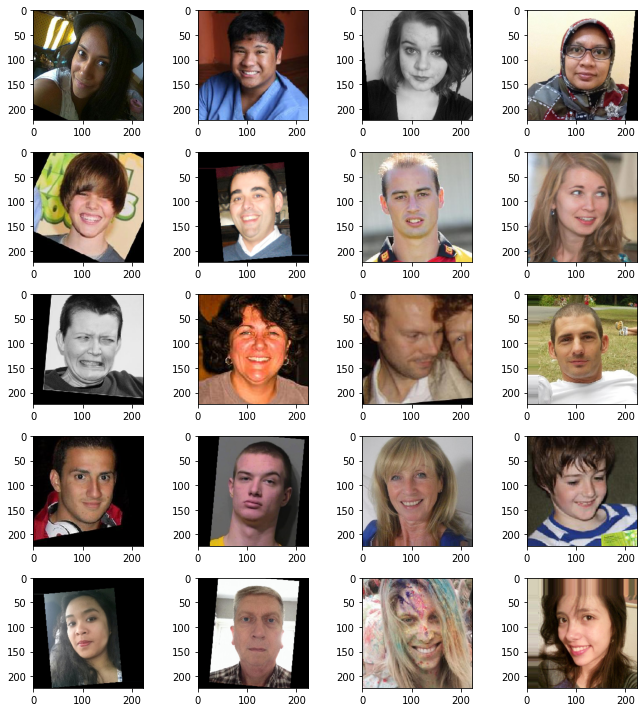

In [24]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()

**Выводы по исследовательскому анализу данных**

1. Выборка содержит 7591 фотографий, для каждой из них указан возраст человека.
2. Самый распространенный возраст людей на фотографиях от 15 до 40 лет. Средний возраст - 30 лет, но также есть люди с возрастом 1 и 100 лет.
3. Фотографии цветные и чернобелые.
4. Качество некоторых фотографий низкое, на них присутствуют посторонние предметы, другие люди, грязь на лице, также некоторые фотографии повернуты.

**С учетом вышесказанного, будет сложно создать модель для оценки возраста людей по имеющейся выборке.**

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1./255
    )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255
    )
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(
        optimizer=optimizer, 
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Epoch 1/10
2025-03-28 12:14:19.638622: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-28 12:14:19.998199: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 57s - loss: 198.5926 - mae: 10.3382 - val_loss: 373.6701 - val_mae: 14.3831
Epoch 2/10
356/356 - 47s - loss: 82.9879 - mae: 6.8990 - val_loss: 119.9879 - val_mae: 8.3760
Epoch 3/10
356/356 - 48s - loss: 58.3706 - mae: 5.8200 - val_loss: 226.7049 - val_mae: 12.4699
Epoch 4/10
356/356 - 49s - loss: 43.3464 - mae: 5.0471 - val_loss: 85.6073 - val_mae: 7.0654
Epoch 5/10
356/356 - 48s - loss: 33.7435 - mae: 4.4691 - val_loss: 79.8793 - val_mae: 6.6780
Epoch 6/10
356/356 - 47s - loss: 25.1993 - mae: 3.8531 - val_loss: 67.1348 - val_mae: 6.0931
Epoch 7/10
356/356 - 47s - loss: 19.2677 - mae: 3.4101 - val_loss: 67.5290 - val_mae: 6.2006
Epoch 8/10
356/356 - 51s - loss: 18.1769 - mae: 3.2415 - val_loss: 69.9742 - val_mae: 6.2022
Epoch 9/10
356/356 - 46s - loss: 15.7658 - mae: 3.0084 - val_loss: 74.4621 - val_mae: 6.3124
Epoch 10/10
356/356 - 48s - loss: 13.0546 - mae: 2.7679 - val_loss: 65.4943 - val_mae: 5.9503
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 65.4943 - mae: 5.9503

```

**Выводы по разделу 2**

1. Нейронная сеть построена на ResNet50. 
2. За 10 эпох на тестовой выборке получена метрика MAE 5.9503. Дальнейшее обучение могло улучшить результат, но заняло бы больше времени.

## Анализ обученной модели

Обученная модель имеет высокую точность предсказания возраста покупателей. Модель имеет метрику качества равную 5,95, это означает, что погрешность в определении возраста составляет примерно 6 лет, что является хорошим показателем.